# API Query

- Queries sentinelAPI for a given set of tiles and parameters (especially a given **time period**)
- Saves query result in **out_path** folder.


## I. Downloads needed tiles from *Needed_tiles_selection* for a given time period

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sentinelsat import SentinelAPI
import os
import time
import random
import glob
import pandas as pd
import geopandas as gpd
import seaborn as sns
from datetime import date, timedelta
from calendar import monthrange

from shapely.geometry import MultiPolygon, Point, MultiPoint, GeometryCollection
from shapely.ops import unary_union
from shapely import wkt
import shapely.ops as so
import cartopy.crs as ccrs
from collections import defaultdict
import matplotlib.patches as mpatches

### User Inputs

In [2]:
# Code was designed to work with queries spanning full months - Adaptations might be needed if other choice made
### INPUTS ###
# tiles_file_p = "../data/S2_tiles/sample300_tiles_set_default.npz"
tiles_file_p = "../data/S2_tiles/missing_tiles_with_greenland.csv"
usr_choices_p= "../user_choices.npz"
usr_choices  = np.load(usr_choices_p, allow_pickle=True)
dates        = list(usr_choices['dates'])
out_p        = "../data/product_ids"
fig_p        = "../figures"
#############

- Dates choices

In [3]:
month_index          = 2
start_date, end_date = dates[month_index]
start_date, end_date

(datetime.date(2021, 10, 1), datetime.date(2021, 10, 31))

### API connection

An account on https://scihub.copernicus.eu/ is needed to query the API. Account validation can take 'may take up to a week', normally 2/3 days.

In [4]:
user, password = 'one000', 'visible_password!!!'
api = SentinelAPI(user, password, 'https://apihub.copernicus.eu/apihub')
api

### Targeted tiles

In [5]:
if tiles_file_p[-3:]=="npz":
    data = np.load(tiles_file_p, allow_pickle=True)
    D    = data['D'].item()

    print("type D: ", type(D))
    print("len  D: ", len(D))
    print("item[0]    : ", list(D.items())[0])
    tiles      = list(D.keys())
elif tiles_file_p[-3:]=="csv":
    t = pd.read_csv(tiles_file_p)
    t.rename(columns={"Unnamed: 0": "tile_id"}, inplace=True)
    t.set_index('tile_id', inplace=True)
    tiles = list(t.index)

In [6]:
len(tiles)

10046

### Query arguments

- 'producttype':
    - 'S2MSI1C' corresponds to Top of Atmosphere products (without atmos. correction), globally available
    - 'S2MSI2A' corresponds to Bottom of Atmosphere products (with atmos. correction), not globally available on this end-point at least
- See https://sentinels.copernicus.eu/web/sentinel/missions/sentinel-2/data-products and other docs for more information.

In [7]:
query_kwargs = {
    'platformname': 'Sentinel-2',
    'producttype' : 'S2MSI1C',
    'date'        : (start_date, end_date) #,
    # 'ondemand'    : 'true'                        # All queried products are offline, don't know why...
}

### API query
- Select all tiles within time window. Than, retain tiles with least cloud cover % for each possible (tile,orbit)
- Results are put in an ordered dictionnary.

In [20]:
query_ID = np.random.randint(100000)
# List of targeted tiles
L_target = tiles[:]
# count products
c = 0
# tiles with no matching products
Lmiss = []

# All considered products
products = OrderedDict()

for i,tile in enumerate(L_target):
    print(i, tile)
    kw           = query_kwargs.copy()
    kw['tileid'] = tile
    pp           = api.query(**kw)
    # No tiles
    if len(pp)==0:
        Lmiss.append(tile)
    # At least one tile
    else:
        products.update(pp)
        

print("Nb of found tiles\t:", (len(L_target) - len(Lmiss)), " / ",len(L_target))
print(len(Lmiss), "tiles not found\t:", Lmiss)

# Saves result
np.savez(os.path.join(out_p, str(start_date)+'_'+str(end_date)+'_queryID'+str(query_ID)+'_before_selection_wh_greenland.npz'),
         products = products)

# # When loading a products dictionary instead of querying the API
# data     = np.load(os.path.join(out_p, '2021-10-01_2021-10-31_queryID92386_after_selection.npz'), allow_pickle=True)
# products = data["products"].item()

In [21]:
# Conversion
products_df = api.to_dataframe(products).convert_dtypes()
print(products_df.shape)
products_df.head()

(22330, 37)


title  \
6057ac71-905d-49cd-b12a-c1d21f6e56be  S2B_MSIL1C_20211005T221939_N0301_R029_T01LBC_2...   
17f288da-3719-4412-938a-8b4b3a314e90  S2A_MSIL1C_20211027T220921_N0301_R129_T01LBC_2...   
f4400c27-2bc3-4c01-bd85-a8790381d8cf  S2B_MSIL1C_20211025T221939_N0301_R029_T60KWE_2...   
f67afc23-9aec-45d5-9835-be1006fc7ced  S2A_MSIL1C_20211013T223021_N0301_R072_T60KWE_2...   
6960b190-ade5-4ba3-b623-85e576a2e90d  S2B_MSIL1C_20211015T221939_N0301_R029_T60KXG_2...   

                                                                                   link  \
6057ac71-905d-49cd-b12a-c1d21f6e56be  https://apihub.copernicus.eu/apihub/odata/v1/P...   
17f288da-3719-4412-938a-8b4b3a314e90  https://apihub.copernicus.eu/apihub/odata/v1/P...   
f4400c27-2bc3-4c01-bd85-a8790381d8cf  https://apihub.copernicus.eu/apihub/odata/v1/P...   
f67afc23-9aec-45d5-9835-be1006fc7ced  https://apihub.copernicus.eu/apihub/odata/v1/P...   
6960b190-ade5-4ba3-b623-85e576a2e90d  https://apihub.copernicus.eu/apihub/odata/v1/P...   

                                                                       link_alternative  \
6057ac71-905d-49cd-b12a-c1d21f6e56be  https://apihub.copernicus.eu/apihub/odata/v1/P...   
17f288da-3719-4412-938a-8b4b3a314e90  https://apihub.copernicus.eu/apihub/odata/v1/P...   
f4400c27-2bc3-4c01-bd85-a8790381d8cf  https://apihub.copernicus.eu/apihub/odata/v1/P...   
f67afc23-9aec-45d5-9835-be1006fc7ced  https://apihub.copernicus.eu/apihub/odata/v1/P...   
6960b190-ade5-4ba3-b623-85e576a2e90d  https://apihub.copernicus.eu/apihub/odata/v1/P...   

                                                                              link_icon  \
6057ac71-905d-49cd-b12a-c1d21f6e56be  https://apihub.copernicus.eu/apihub/odata/v1/P...   
17f288da-3719-4412-938a-8b4b3a314e90  https://apihub.copernicus.eu/apihub/odata/v1/P...   
f4400c27-2bc3-4c01-bd85-a8790381d8cf  https://apihub.copernicus.eu/apihub/odata/v1/P...   
f67afc23-9aec-45d5-9835-be1006fc7ced  https://apihub.copernicus.eu/apihub/odata/v1/P...   
6960b190-ade5-4ba3-b623-85e576a2e90d  https://apihub.copernicus.eu/apihub/odata/v1/P...   

                                                                                summary  \
6057ac71-905d-49cd-b12a-c1d21f6e56be  Date: 2021-10-05T22:19:39.024Z, Instrument: MS...   
17f288da-3719-4412-938a-8b4b3a314e90  Date: 2021-10-27T22:09:21.024Z, Instrument: MS...   
f4400c27-2bc3-4c01-bd85-a8790381d8cf  Date: 2021-10-25T22:19:39.024Z, Instrument: MS...   
f67afc23-9aec-45d5-9835-be1006fc7ced  Date: 2021-10-13T22:30:21.024Z, Instrument: MS...   
6960b190-ade5-4ba3-b623-85e576a2e90d  Date: 2021-10-15T22:19:39.024Z, Instrument: MS...   

                                     ondemand    datatakesensingstart  \
6057ac71-905d-49cd-b12a-c1d21f6e56be    false 2021-10-05 22:19:39.024   
17f288da-3719-4412-938a-8b4b3a314e90    false 2021-10-27 22:09:21.024   
f4400c27-2bc3-4c01-bd85-a8790381d8cf    false 2021-10-25 22:19:39.024   
f67afc23-9aec-45d5-9835-be1006fc7ced    false 2021-10-13 22:30:21.024   
6960b190-ade5-4ba3-b623-85e576a2e90d    false 2021-10-15 22:19:39.024   

                                          generationdate  \
6057ac71-905d-49cd-b12a-c1d21f6e56be 2021-10-05 23:26:21   
17f288da-3719-4412-938a-8b4b3a314e90 2021-10-27 23:26:06   
f4400c27-2bc3-4c01-bd85-a8790381d8cf 2021-10-25 23:18:00   
f67afc23-9aec-45d5-9835-be1006fc7ced 2021-10-13 23:46:17   
6960b190-ade5-4ba3-b623-85e576a2e90d 2021-10-15 23:25:03   

                                               beginposition  \
6057ac71-905d-49cd-b12a-c1d21f6e56be 2021-10-05 22:19:39.024   
17f288da-3719-4412-938a-8b4b3a314e90 2021-10-27 22:09:21.024   
f4400c27-2bc3-4c01-bd85-a8790381d8cf 2021-10-25 22:19:39.024   
f67afc23-9aec-45d5-9835-be1006fc7ced 2021-10-13 22:30:21.024   
6960b190-ade5-4ba3-b623-85e576a2e90d 2021-10-15 22:19:39.024   

                                                 endposition  ...  \
6057ac71-905d-49cd-b12a-c1d21f6e56be 2021-10-05 22:19:39.024  ...   
17f288da-3719-4412-938a-

In [23]:
print(products_df.link[0])
print(products_df.link_alternative[0])
print(products_df.link_icon[0])
print(products_df.identifier[0])

L = [(tile, orbit) for tile, orbit in zip(products_df.tileid, products_df.relativeorbitnumber)]
print("Total #(tile, orbit)\t:", len(L))
print("Unique #(tile, orbit)\t:", len(set(L)))

https://apihub.copernicus.eu/apihub/odata/v1/Products('6057ac71-905d-49cd-b12a-c1d21f6e56be')/$value
https://apihub.copernicus.eu/apihub/odata/v1/Products('6057ac71-905d-49cd-b12a-c1d21f6e56be')/
https://apihub.copernicus.eu/apihub/odata/v1/Products('6057ac71-905d-49cd-b12a-c1d21f6e56be')/Products('Quicklook')/$value
S2B_MSIL1C_20211005T221939_N0301_R029_T01LBC_20211005T232621


### Less cloudy products selection per (tile, orbit) pair

In [27]:
# # When loading a products already filtered dictionary instead of processing the API query or saved file
# data        = np.load(os.path.join(out_p, '2021-10-01_2021-10-31_queryID92386_after_selection.npz'), allow_pickle=True)
# dataset_dic = data["products"].item()
# len(dataset_dic)


# print(products_geodf.columns)
print("SIZE avail. products\t: ", api.get_products_size(products), 'GB')
grouped = products_df.groupby(['tileid', 'relativeorbitnumber'], sort=False, group_keys=False)
dataset = grouped.apply(lambda x: x.sort_values(('cloudcoverpercentage'), ascending=True).head(1))
print("Dataset\t:", dataset.shape[0])
dataset_dic = dataset.to_dict(into=OrderedDict, orient='index')

22330

### Selected products size in GB

In [28]:
print("SIZE final selection\t: ", api.get_products_size(dataset_dic), 'GB')
print("SIZE for a year\t\t: ", api.get_products_size(dataset_dic)*12, 'GB')

SIZE final selection	:  11563.94 GB
SIZE for a year		:  138767.28 GB


### Saves API query results

In [17]:
# # out_file = os.path.join(out_p, str(start_date)+'_'+str(end_date)+'_queryID'+str(query_ID)+'_after_selection_wh_greenland')
# print("out_file:", out_file)

# # Saves result
# np.savez(out_file,
#          products = dataset_dic,
#          Lunfound = Lmiss)

out_file: ../data/product_ids/2021-10-01_2021-10-31_queryID4006_after_selection_wh_greenland


In [18]:
list(dataset_dic.items())[15][0]

'3897bd47-3cbb-4010-b274-ed81203ed4ab'

### Download test

In [ ]:
# api.download(list(dataset_dic.items())[15][0])
# api.download_all(dataset_dic)

### Products map

In [44]:
# World
path = gpd.datasets.get_path('naturalearth_lowres')
world= gpd.read_file(path, crs='WGS84')
world= world[(world.name!="Antarctica")]
# world= world[(world.name!="Greenland")]

In [107]:
# Prepares products geomtries plot
df             = pd.DataFrame(dataset_dic).T
df['geometry'] = df['footprint'].apply(wkt.loads)
gdf            = gpd.GeoDataFrame(df, geometry='geometry', crs=world.crs)

In [134]:
# Zoom on a given country only
country_str   = "Peru"
country_geo   = world[(world.name==country_str)]
tiles_country = gpd.sjoin(gdf, country_geo, how='inner', op='intersects')

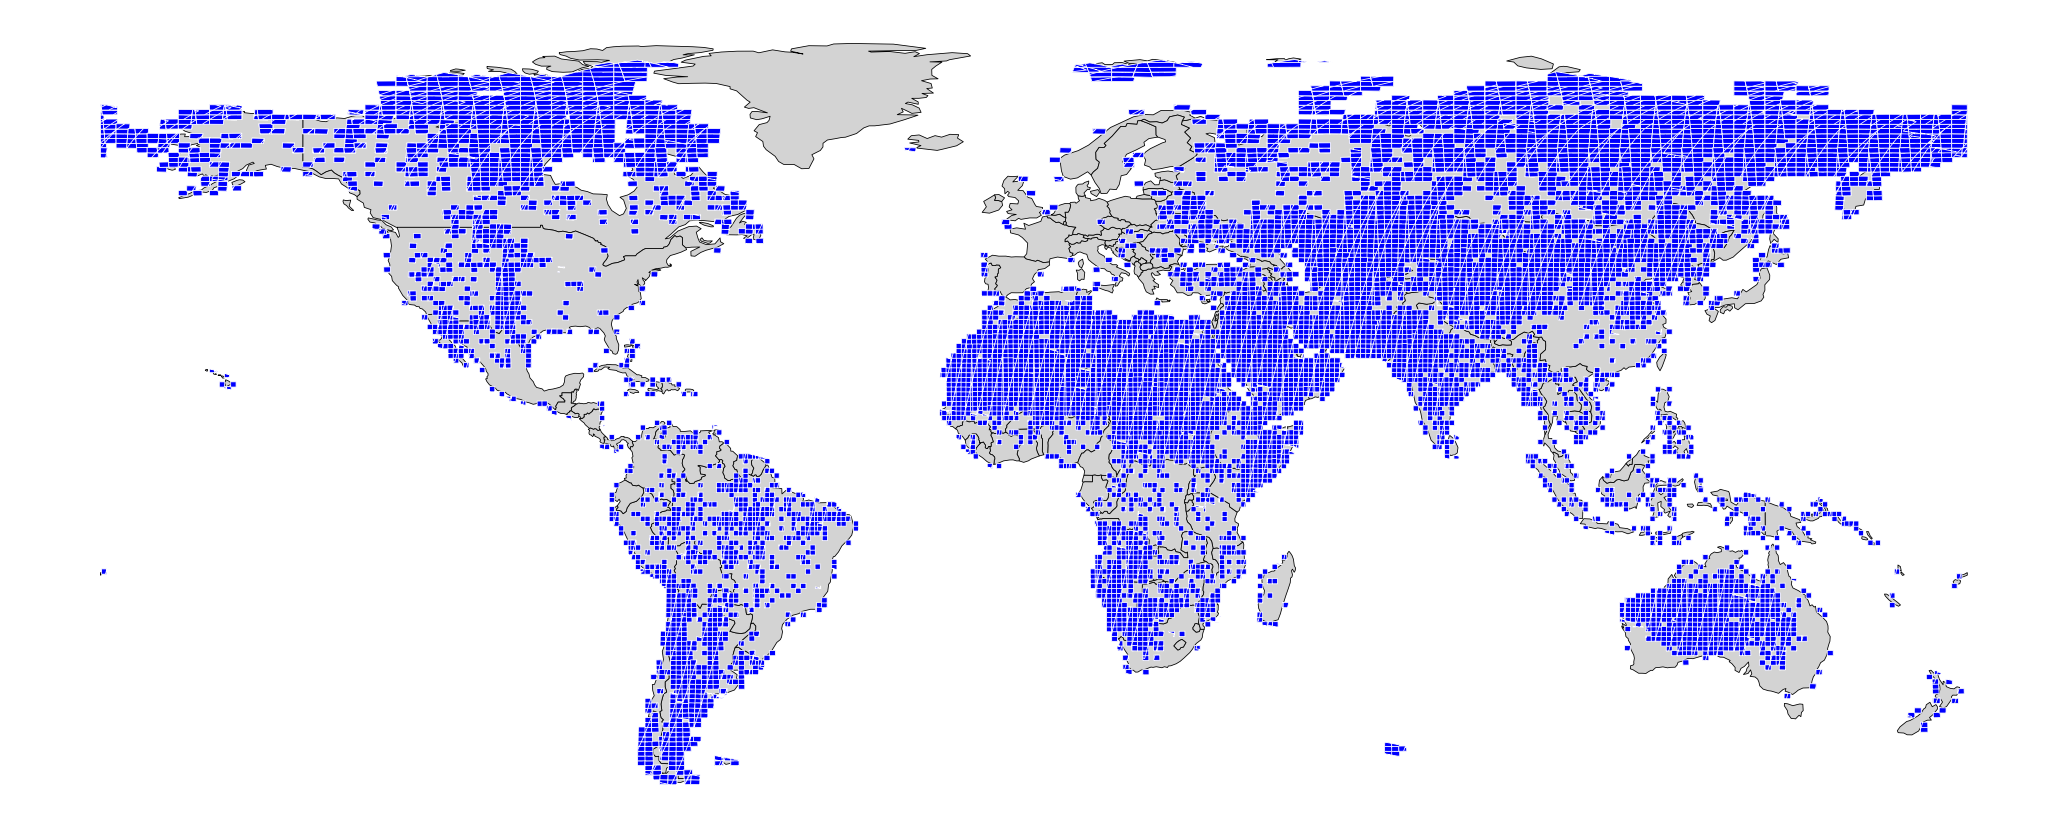

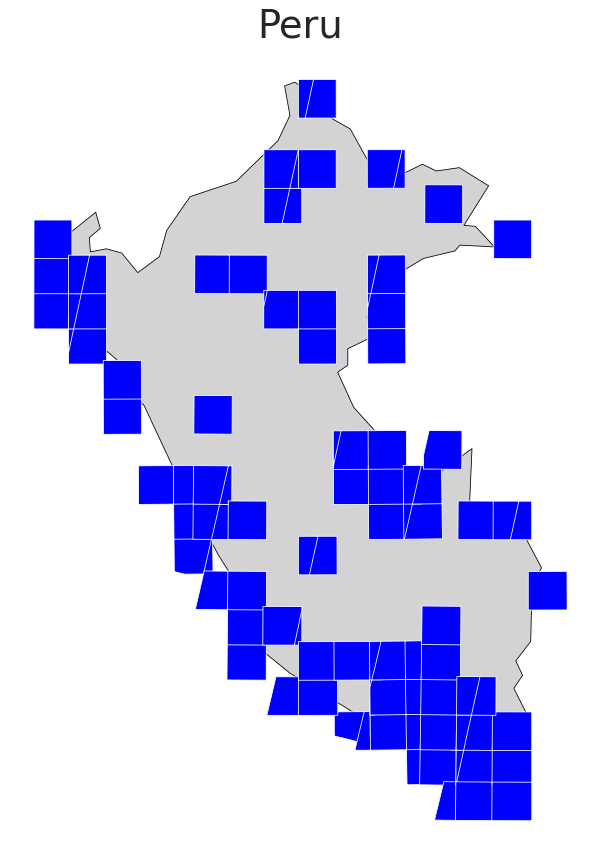

In [135]:
sns.set_theme(context='paper', font_scale=4)

# World
base    = world.plot(figsize=(45 ,15), color='lightgrey', edgecolor='black')
ax_map  = gdf.plot(color='blue', ax=base)
plt.axis('off');
# plt.savefig('World_missing_products_map_default.pdf')

# Country
base    = country_geo.plot(figsize=(45 ,15), color='lightgrey', edgecolor='black')
ax_map  = tiles_country.plot(color='blue', ax=base)
plt.title(country_str)
plt.axis('off');
plt.savefig(country_str+'_missing_products_map_default.png')